In [1]:
# import the module
import tweepy
import requests
import textblob
from textblob import TextBlob
from statistics import mean
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import datetime as dt
import yfinance as yf
from dotenv import load_dotenv
import os
from pathlib import Path
import re
import panel as pn
import pandas as pd
import numpy as np
from panel.interact import interact 
import plotly.express as px
pn.extension("plotly")
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import spacy
nlp = spacy.load('en_core_web_sm')
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\ooika\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Loads environment variables
load_dotenv()

# These keys are located under Twitter Developer Console 'Projects and Apps'
# You need to create a 'Standalone App' and generate the keys
consumer_key = os.getenv("consumer_key")
consumer_secret = os.getenv("consumer_secret")
access_token = os.getenv("access_token")
access_token_secret = os.getenv("access_token_secret")

# This key is located under Twitter Developer Console 'Products > Premium > Dev Environments'
# You have to create a 'Search Tweets: Full ArchiveSandbox Dev Environment' and use the name of the dev env
twitter_sandbox = os.getenv("twitter_sandbox")

# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  
# set access to user's access key and access secret 
auth.set_access_token(access_token, access_token_secret)
  
# calling the api 
api = tweepy.API(auth)

In [3]:
### Only Run this when ready to start using up Twitter searches. Can load a CSV file down below for testing purposes!!
# Search of Twitter Archive, from start date and incrementing one day at a time. Takes the last 100 tweets of the day.
# Analyses the sentiment of each tweet, creates a list of the individual sentiments, then takes the mean value for the day.
# Creates a list of sentiment values, one value for each day
# Creats one giant list of raw text from all the tweets for the search period for wordcloud generation

searchterms = 'bitcoin'
startdate = dt.datetime(2021, 2, 8)
daterange = 50
yfstartdate = startdate + dt.timedelta(days=1)
yfenddate = startdate + dt.timedelta(days = daterange)

yfstart = yfstartdate.strftime("%Y-%m-%d")
yfend = yfenddate.strftime("%Y-%m-%d")
BTC = yf.Ticker('BTC-USD')
df_BTC = BTC.history(start=yfstart, end=yfend)

daysentiment = []
rawtexttotal = []

for i in range(daterange):
        
    fDate = startdate.strftime("%Y%m%d%H%M")
    startdate += dt.timedelta(days=1)
    tDate = startdate.strftime("%Y%m%d%H%M")
    
    results = api.search_full_archive(twitter_sandbox, searchterms, fromDate=fDate, toDate=tDate, maxResults=100)
    
    
    senti = []
    rawtext = []

    for tweet in results[0:100]:
        #print(tweet.text)
        #print(tweet.created_at)
        analysis = TextBlob(tweet.text)
        score = analysis.sentiment.polarity
        #print()
        #print(f"Sentiment= {score}")
        #print()
        senti.append(score)
        rawtext.append(tweet.text)
    
    daysentiment.append(mean(senti))
    rawtexttotal.append(rawtext)

    
#print(daysentiment)
df_BTC['Sentiment'] = daysentiment

# Save price and sentiment results to CSV
df_BTC.to_csv(f"{searchterms}.csv")

In [3]:
# Reading the saved bitcoin csv file
df_merged = pd.read_csv('bitcoin.csv', index_col='Date')
df_merged.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Sentiment
Date,,,,,,,,
2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,101467222687,0,0,0.064985
2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,91809846886,0,0,0.029858
2021-02-10,46469.761719,47145.566406,43881.152344,44918.183594,87301089896,0,0,0.082648
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,0,0,0.122292
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,0,0,0.101058


In [4]:
df_merged.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Sentiment
Date,,,,,,,,
2021-03-25,52726.746094,53392.386719,50856.570312,51704.160156,67999812841,0,0,0.128783
2021-03-26,51683.011719,55137.312500,51579.855469,55137.312500,56652197978,0,0,0.123210
2021-03-27,55137.566406,56568.214844,54242.910156,55973.511719,47266542233,0,0,0.148560
2021-03-28,55974.941406,56610.312500,55071.113281,55950.746094,47686580918,0,0,0.120989
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57625587027,0,0,0.142306


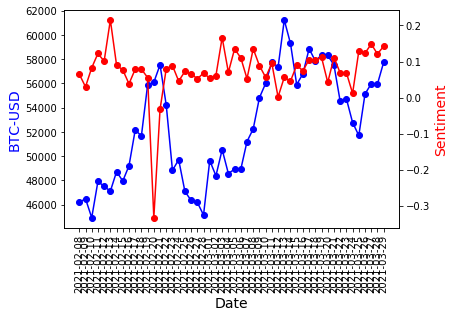

In [5]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df_merged.index, df_merged["Close"], color="blue", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("BTC-USD",color="blue",fontsize=14)
plt.xticks(rotation = 90)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_merged.index, df_merged["Sentiment"],color="red",marker="o")
ax2.set_ylabel("Sentiment",color="red",fontsize=14)
plt.rcParams["figure.figsize"] = [80,40]
plt.show()

In [6]:
fig.savefig('BTC_sentiment.png')

In [7]:
# This cell will come up with an error if the Twitter API was not pinged before.
# Skip to next cell and read the raw text file.

# Saving the raw text total as CSV
df = pd.DataFrame(rawtexttotal)
df.to_csv('rawtext.csv') 

NameError: name 'rawtexttotal' is not defined

In [8]:
# Reading the saved raw text file
rawtext_df = pd.read_csv('rawtext.csv', index_col=0)
rawtext_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,RT @VentureCoinist: Today is the largest candl...,RT @VentureCoinist: Today is the largest candl...,RT @jsfx891hi1t2q: ตีหม้อเผด็จการ 10กพ64 พบกัน...,RT @scottmelker: Next time you consider buying...,RT @AltcoinDailyio: If you think Tesla's #bitc...,#altcoin yatırımcısı #Bitcoin yükselirken kork...,RT @CoinDesk: BREAKING: @Tesla has disclosed p...,RT @StockTweets6: Bitcoin Billionaire Cameron ...,@zerohedge HUT8 = Undervalued Bitcoin Miner,Check the profile for fractional $BTC offer th...,...,RT @LionShare11: Since Elastos is the future b...,Moon it Lads! #Bitcoin https://t.co/LWMYfULVnV,#cryptocurrency going up steeply in the last c...,⏱️ +7600$ en une journée pour BTC.\nC'est un r...,@Snakeman217 @TIKILICIOUSNESS @bessiambre @ben...,@elonmusk @elonmusk hyped everyone for dogecoi...,@calzoneop On the flip side people get so bore...,海外取引所 CryptoGT\n仮想通貨fx\n面倒な本人確認なし\n最大レバ500倍\nク...,RT @zerohedge: Bitcoin 46K,A large Discord trading group just pumped #bit...
1,¿Ósea hace un mes en Reddit sabían que $TSLA c...,RT @maxkeiser: 10 yrs ago \nMax &amp; Stacy in...,RT @chamath: Loss porn: In 2014 I bought an em...,RT @APompliano: I'll be on @SquawkCNBC Wednesd...,"@patrickluberus @NanoTipBot Because I'm not ""b...",RT @Dogecoinxx: All the negativity is coming f...,RT @ElectRyanDorsey: Super confused about how ...,RT @BTC_Archive: Larry Ellison’s Oracle is rep...,Former British MP says central banks should ba...,@maxkeiser I can buy much tacos with my bitcoi...,...,RT @DrBitcoinMD: Michael Saylor's full appeara...,https://t.co/8yEAvhXRLU \n#Doge #Bitcoin #Bina...,RT @WhatBitcoinDid: WBD309 - Tesla’s $1.5bn #B...,RT @MrMessenger: การที่ Tesla เข้าซื้อ Bitcoin...,RT @bbcmundo: La apuesta de Tesla por bitcoin ...,A Tesla for a bitcoin: Musk drives up cryptocu...,RT @info_united_us: @elonmusk #Dogecoin tweets...,RT @cz_binance: If you bought #bitcoin before ...,RT @holdthedoge: The joke IS on #Bitcoin • Hol...,Time for plan b #bitcoin
2,"RT @Breedlove22: ""Perhaps it is better that a ...",RT @APompliano: MasterCard jumping into Bitcoi...,@f2pool_official Communists. Stop dumping Bit...,@naval Buy #Bitcoin Fuck this.,RT @AlyssaAshleyC: 3. This is like how MLMs ar...,This is precisely what HODLers ask for! ECB's ...,RT @Dehkunle: The last Uber driver i ordered i...,@Ayfer08Taylan Para varken bitcoin vardı da bi...,Mastercard Will Let Merchants Accept Payments ...,"RT @WhaleTrades: 📉💴$2,172,988 $ETH SHORTED @$1...",...,RT @BBC_Future: Bitcoin uses more electricity ...,@SessomsRicky @Skelkjaerr @elonmusk Think of i...,@Bitcoin_K_S_A خليك مسالم افضل لاجل تزيد ارباح...,RT @CryptoBac: #Bitcoin $btc $crypto https://t...,RT @MeasurableData: We continued to work with ...,"RT @hesaplar361: #AVAX ın 1-1,5 yıl içinde 100...","@garyblack00 Imagine you're the CEO of $MSTR, ...",RT @APompliano: MasterCard jumping into Bitcoi...,RT @tomkessleratx: @RoKhanna @arindube People ...,RT @rcwhalen: @EconguyRosie I can't figure out...
3,RT @Ashwsbreal: #BreakingNews 📰 \n\n#Bitcoin O...,#Bitcoin is free market revolution without vio...,RT @OTC_Bitcoin: Want $100 worth of bitcoin?\n...,RT @firstladyship: BREAKING: Mastercard will l...,#Bitcoin https://t.co/bWSkcJJLq4,RT @businessinsider: Uber CEO says the company...,RT @BITVOLT7: I literally just sent a Bitcoin ...,"RT @lubrio: Venezuela, entre los 10 países con...",RT @WazirXIndia: Uber CEO says the company wil...,RT @DocumentingBTC: Someone just transfered 19...,...,@Bitlocityio We are very excited to participat...,RT @MoonOverlord: The Not Going To Make It Sta...,"RT @RobertSB84: @JayHao8 $xep is instant, near...",something told me to transfer my bitcoin into ...,RT @DocumentingBTC: The first #Bitcoin ETF in ...,BITCOIN AFFILIATE PROGRAM WITH INSTANT PATOUTS...,"RT @Crypto_Mags: LADIES &amp; GENTS, WE HAVE T...",RT @SputnikInt: Andrew Yang pledges to make NY...,RT @DocumentingBTC: The first #Bitcoin ETF in ...,"c'mon #Bitcoin, do that $50k ATH thing. https:

In [9]:
# Changing the structure of the CSV from 500 rows & 101 columns to something readable 5000 rows × 1 columns
final_text = []
for index, row in rawtext_df.iterrows():
    new_text = row
    final_text.extend(new_text)

In [10]:
rawtext2_df = pd.DataFrame(final_text)
rawtext2_df.columns = ['Text']
rawtext2_df.head()

,Text
0,RT @VentureCoinist: Today is the largest candl...
1,RT @VentureCoinist: Today is the largest candl...
2,RT @jsfx891hi1t2q: ตีหม้อเผด็จการ 10กพ64 พบกัน...
3,RT @scottmelker: Next time you consider buying...
4,RT @AltcoinDailyio: If you think Tesla's #bitc...


In [11]:
rawtext2_df.tail()

,Text
4995,RT @BetFastBTC: Former No. 1 pick Appel eyes c...
4996,RT @MudarBrit: @FaroukKaliel @Matt_Haioz @m___...
4997,RT @a3voices: \1 This. The truth is getting ou...
4998,RT @Psolemn: เราแนะนำมากๆให้ทุกคนศึกษาเรื่องเง...
4999,RT @Sweepsgg: I’m giving $100 to one lucky fol...


In [30]:
# Tokenizing text
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

#Expand the default stopwords list if necessary
sw_addon = {'u', 'it', 's', 'as'}

# Complete the tokenizer function
def process_text(doc):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', doc)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw]
    return ' '.join(output)

# Create the input text for a word cloud
big_string = ' '.join(rawtext2_df['Text'])
input_text = process_text(big_string)
input_text = input_text.replace('rt', '') #Removing rt
input_text = input_text.replace('de', '') #Removing rt
input_text = input_text.replace('ha', '') #Removing rt
input_text = input_text.replace('wa', '') #Removing rt
input_text = input_text.replace('im', '') #Removing rt
input_text = input_text.replace('bitcoin', '') #Removing bitcoin
input_text = input_text.replace('@[A-Za-z0-9]', '')

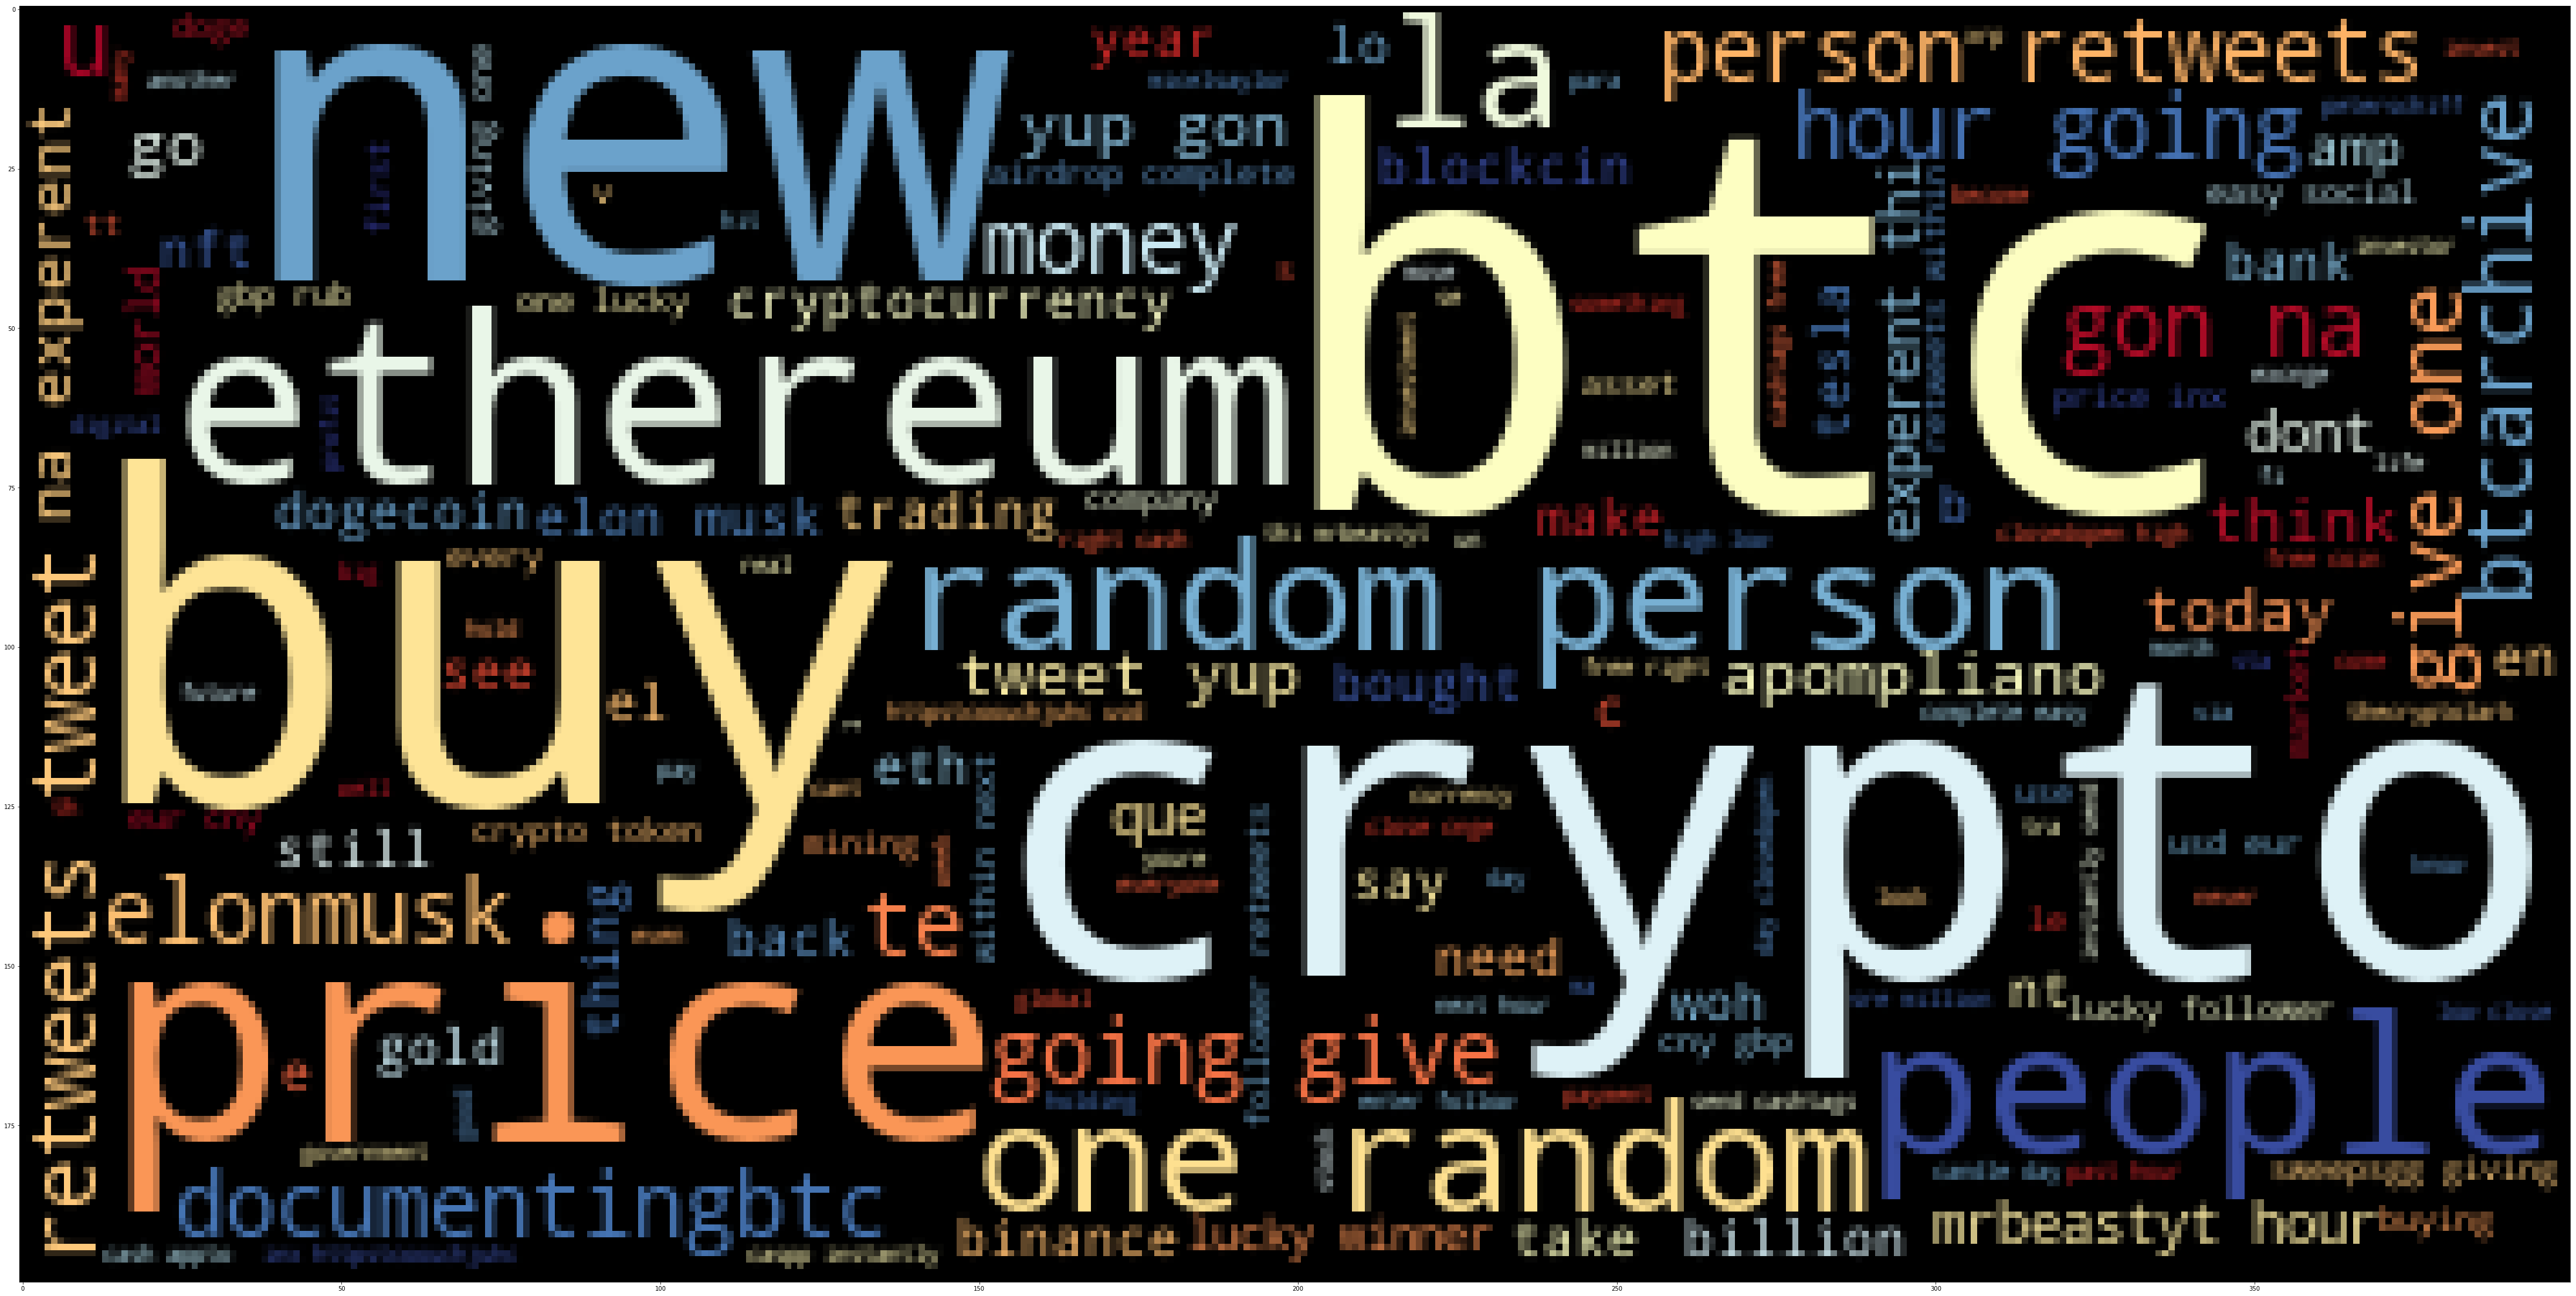

In [31]:
# Generate wordcloud
wc = WordCloud(colormap="RdYlBu").generate(input_text)
plt.rcParams["axes.grid"] = False
plt.imshow(wc)
cloud = wc.to_file('BTC_WC_50days.png')

Word Cloud Saved Successfully


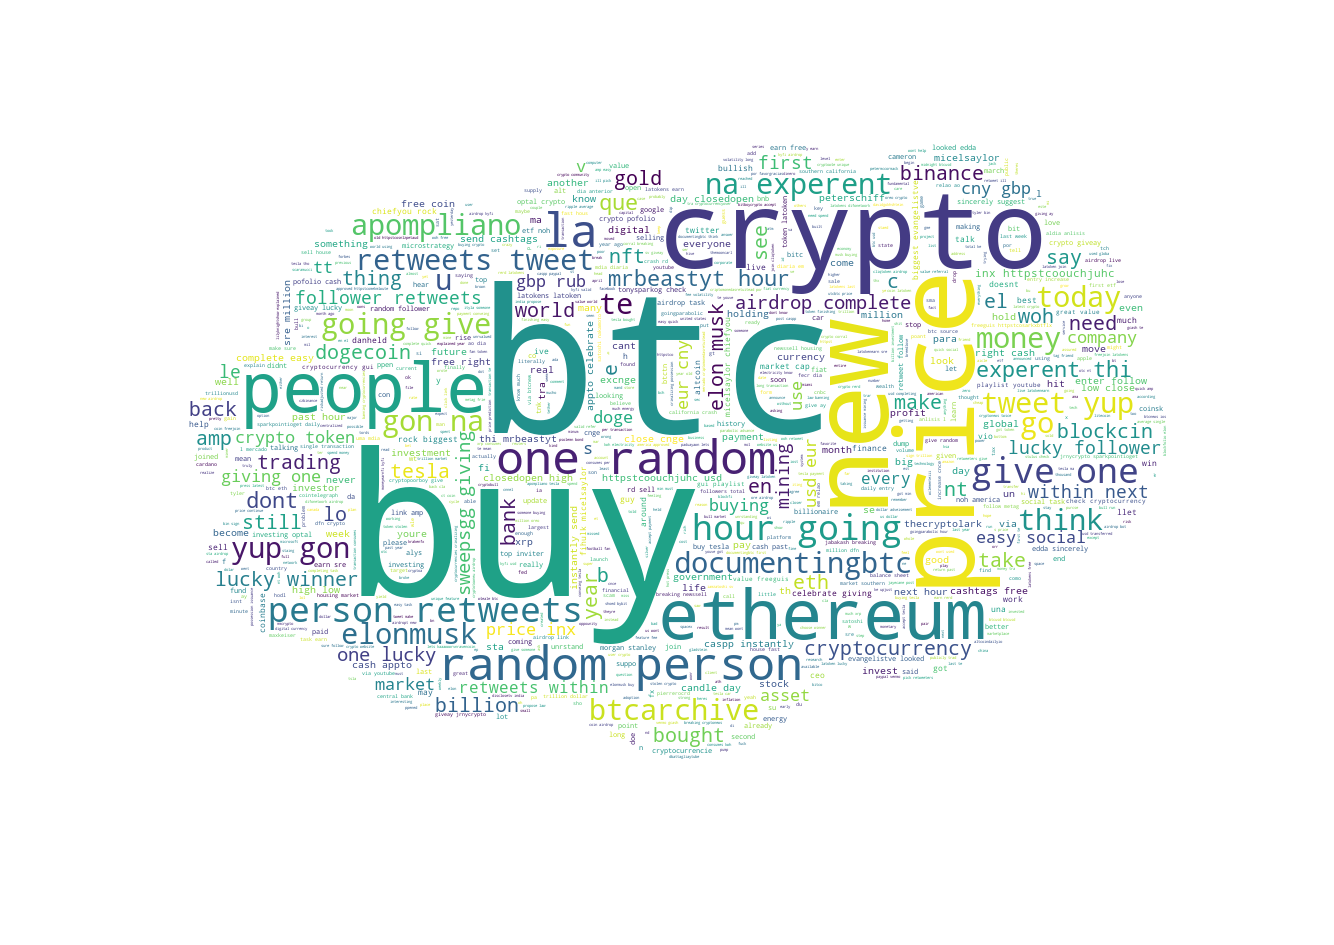

In [32]:
# Creating another word cloud.

from PIL import Image

def create_wordcloud(input_text):
    mask = np.array(Image.open('cloud1.png'))
    wc = WordCloud(background_color='white',
                  mask = mask,
                  max_words=3000,
                  repeat=True)
    wc.generate(str(input_text))
    wc.to_file('wc.png')
    print('Word Cloud Saved Successfully')
    path='wc.png'
    display(Image.open(path))


#Creating wordcloud for all tweets
create_wordcloud(input_text)

In [33]:
#Preparing data to get a bar chart of top 20 words

#Splitting the sentences into words
list_of_sentences = [sentence for sentence in rawtext2_df['Text']]
lines = []
for sentence in list_of_sentences:
    words = sentence.split()
    for w in words:
        lines.append(w)

#Removing punctuation using regular expression
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
lines2 = []
for word in lines:
    if word != '':
        lines2.append(word)
#print(lines2)

#Reducing words to its word stem
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

#Removing all stop words
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)



In [34]:
#Preparing data to get a bar chart of top 20 words for 50 days

#Splitting the sentences into words
list_of_sentences = [sentence for sentence in rawtext2_df['Text']]
lines = []
for sentence in list_of_sentences:
    words = sentence.split()
    for w in words:
        lines.append(w)

#Removing punctuation using regular expression
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
lines2 = []
for word in lines:
    if word != '':
        lines2.append(word)
#print(lines2)

#Reducing words to its word stem
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
stem = []
for word in lines2:
    stem.append(s_stemmer.stem(word))

#Removing all stop words
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

#Using value counts to group all distinct words
df4 = pd.DataFrame(stem2)
df4 = df4[0].value_counts()
df4.head()

bitcoin    3890
rt         2930
crypto      447
btc         394
buy         322
Name: 0, dtype: int64

C:\Users\ooika\anaconda3\envs\pyvizenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


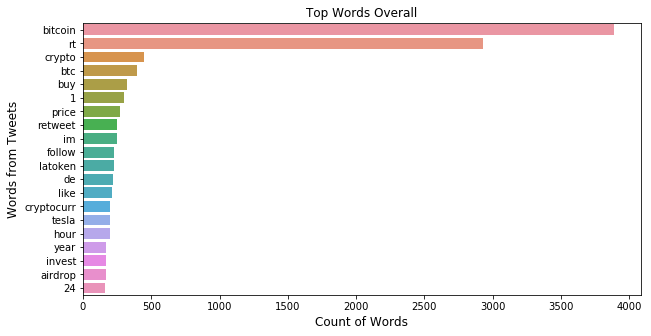

In [35]:
#Choosing top 20 words and plotting it in a barchart
#50 days

df4 = df4[:20,]
plt.figure(figsize=(10,5))
sns.barplot(df4.values, df4.index, alpha=1)
plt.title("Top Words Overall")
plt.ylabel('Words from Tweets', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [36]:
sub_text=[]
pol_text=[]

for index, row in rawtext2_df.iterrows():
    sub_text.append(TextBlob(row['Text']).sentiment.subjectivity)
    pol_text.append(TextBlob(row['Text']).sentiment.polarity)

rawtext2_df['Subjectivity'] = sub_text
rawtext2_df['Polarity'] = pol_text
    
#Show the new dataframe with the two new columns
rawtext2_df.head()

,Text,Subjectivity,Polarity,Analysis
0,RT @VentureCoinist: Today is the largest candl...,0.388571,0.084643,Positive
1,RT @VentureCoinist: Today is the largest candl...,0.388571,0.084643,Positive
2,RT @jsfx891hi1t2q: ตีหม้อเผด็จการ 10กพ64 พบกัน...,0.000000,0.000000,Neutral
3,RT @scottmelker: Next time you consider buying...,0.000000,0.000000,Neutral
4,RT @AltcoinDailyio: If you think Tesla's #bitc...,0.100000,0.000000,Neutral


In [37]:
#Creating the sentiment values
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0:
        return 'Positive'
    
rawtext2_df['Analysis'] = rawtext2_df['Polarity'].apply(getAnalysis)
rawtext2_df.head()

,Text,Subjectivity,Polarity,Analysis
0,RT @VentureCoinist: Today is the largest candl...,0.388571,0.084643,Positive
1,RT @VentureCoinist: Today is the largest candl...,0.388571,0.084643,Positive
2,RT @jsfx891hi1t2q: ตีหม้อเผด็จการ 10กพ64 พบกัน...,0.000000,0.000000,Neutral
3,RT @scottmelker: Next time you consider buying...,0.000000,0.000000,Neutral
4,RT @AltcoinDailyio: If you think Tesla's #bitc...,0.100000,0.000000,Neutral


Can visually see the distribution of the dots. Dots at the 0 line represent neutral tweets. Dots on the lower half represent negative tweets, and top half represents positive


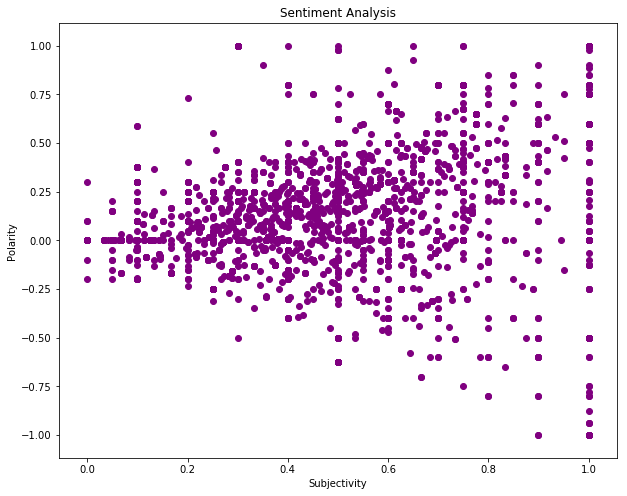

In [25]:
# Plot the polarity and subjectivity
plt.figure(figsize=(10,8))
for i in range(0, rawtext2_df.shape[0]):
    plt.scatter(rawtext2_df['Subjectivity'][i], rawtext2_df['Polarity'][i], color='purple')

plt.title('Sentiment Analysis')
plt.ylabel('Polarity')
plt.xlabel('Subjectivity')
print('Can visually see the distribution of the dots. Dots at the 0 line represent neutral tweets. Dots on the lower half represent negative tweets, and top half represents positive')

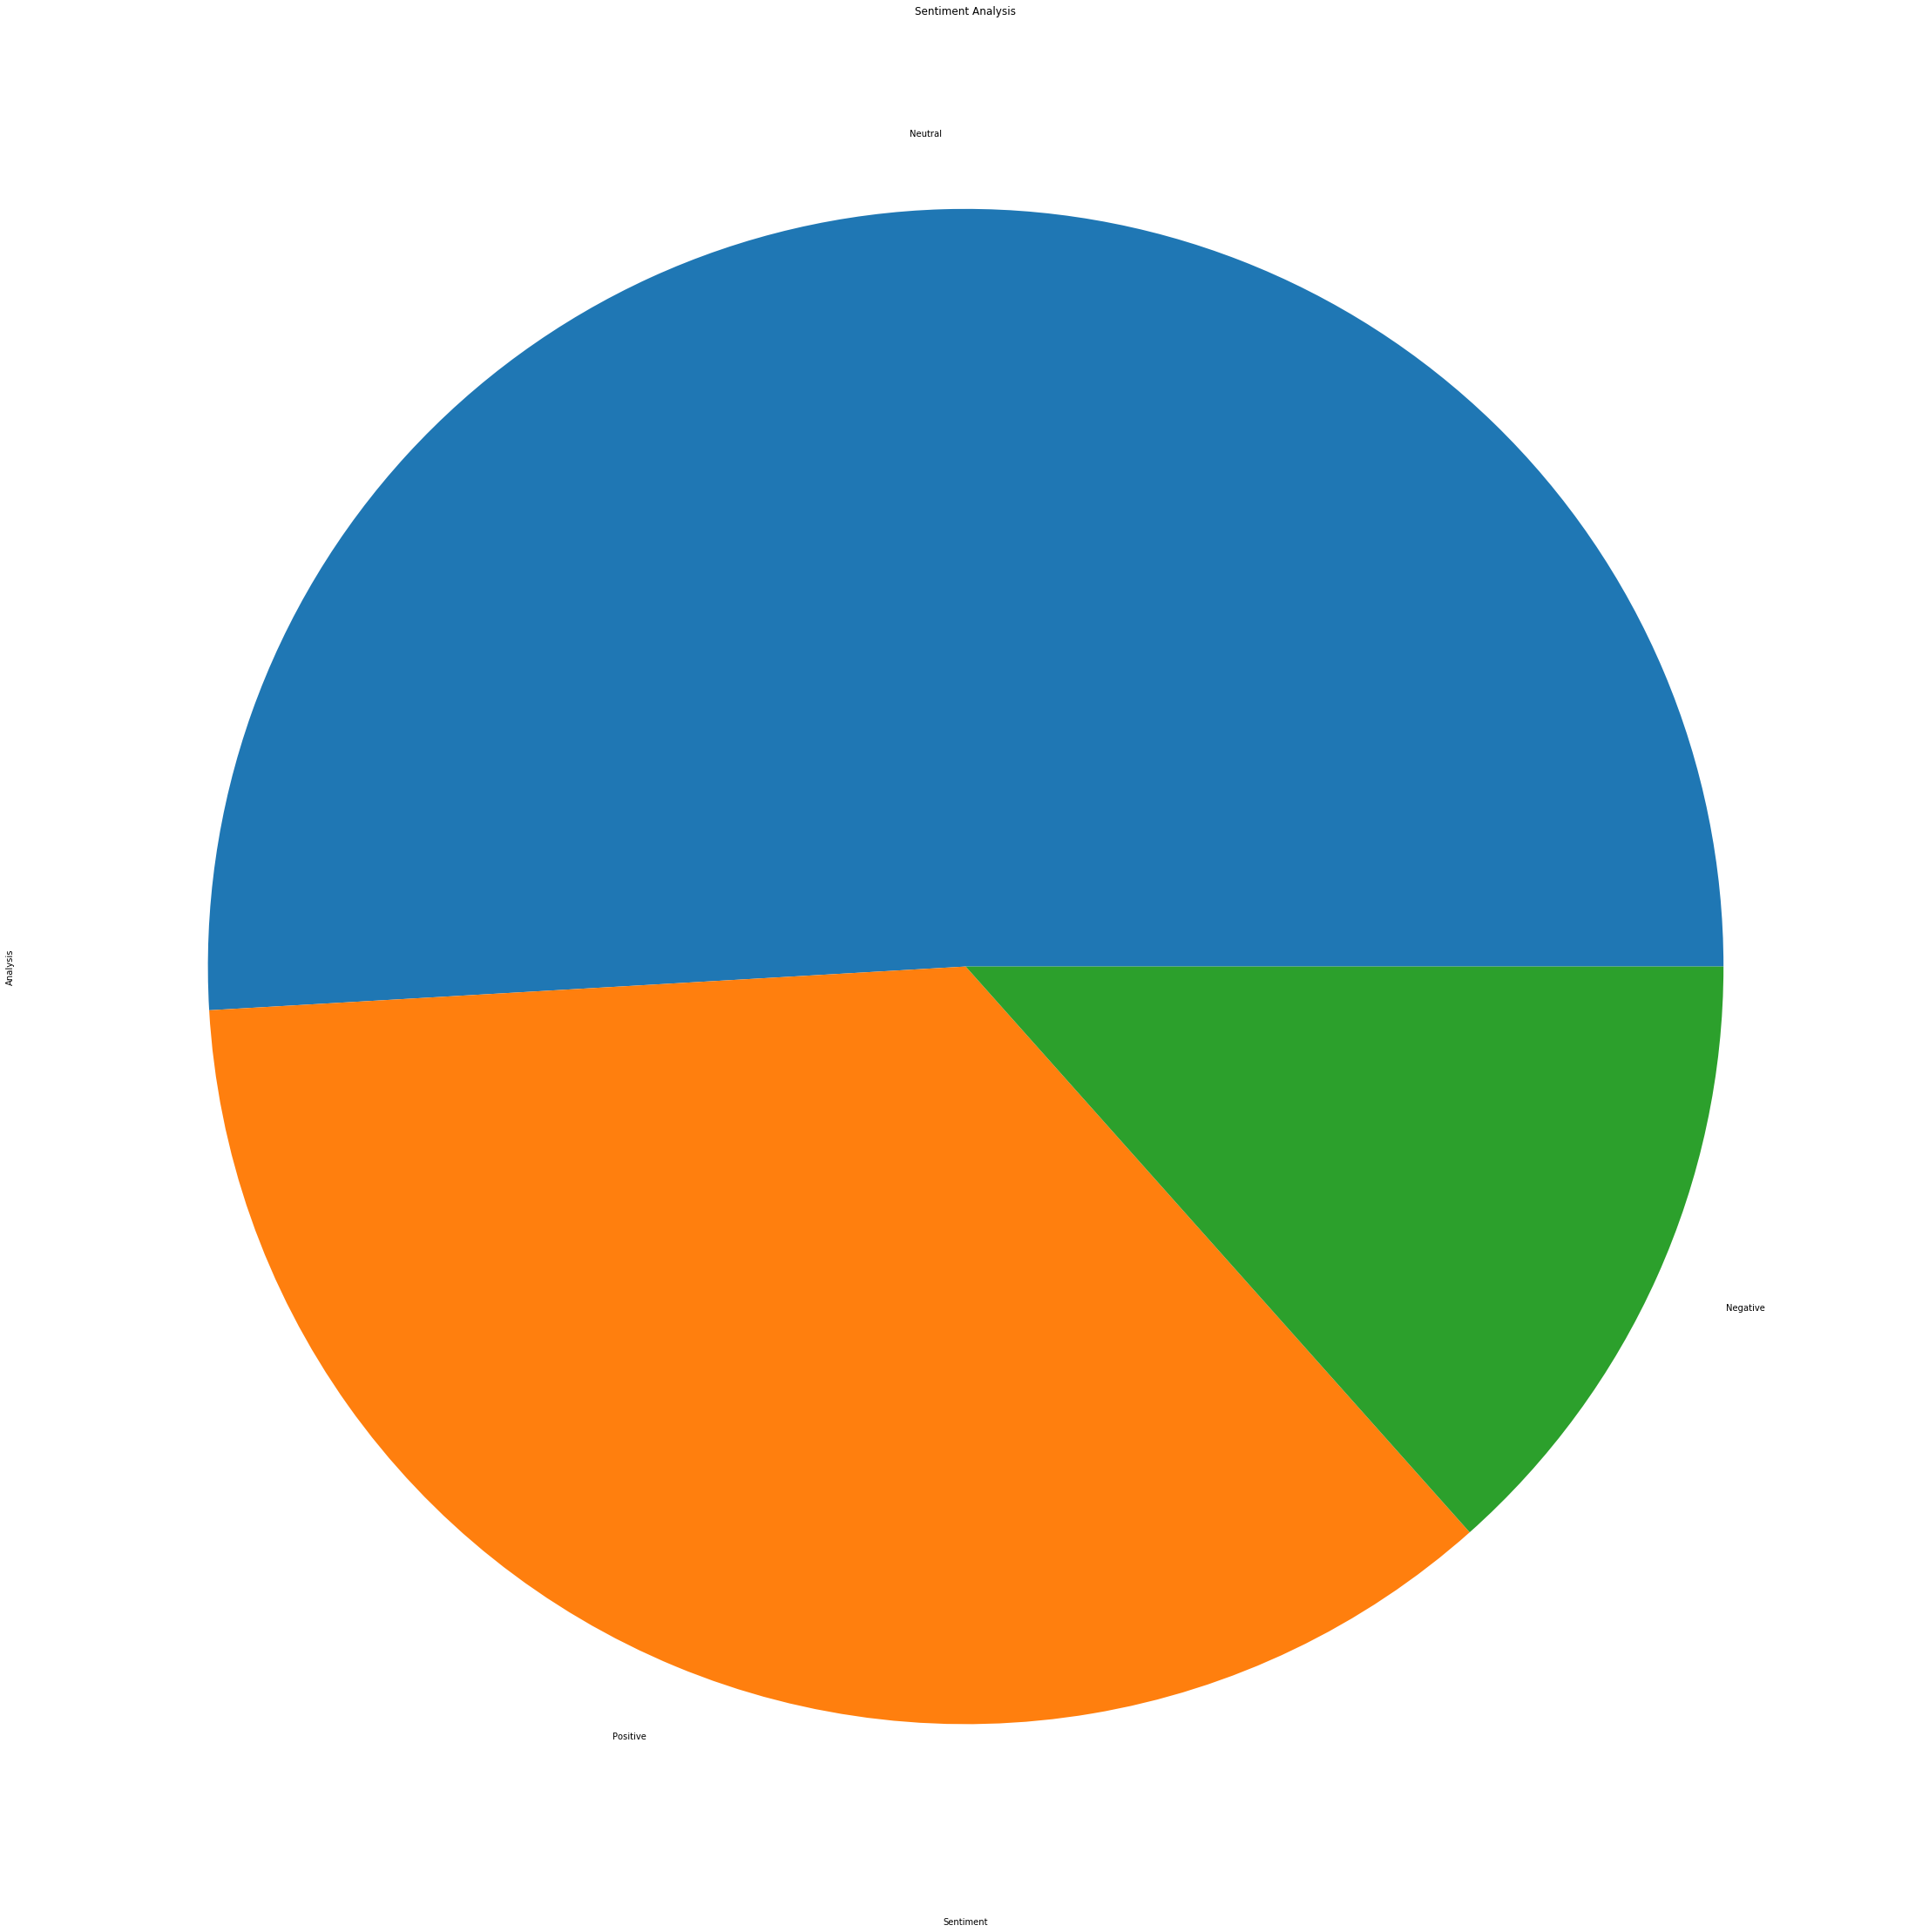

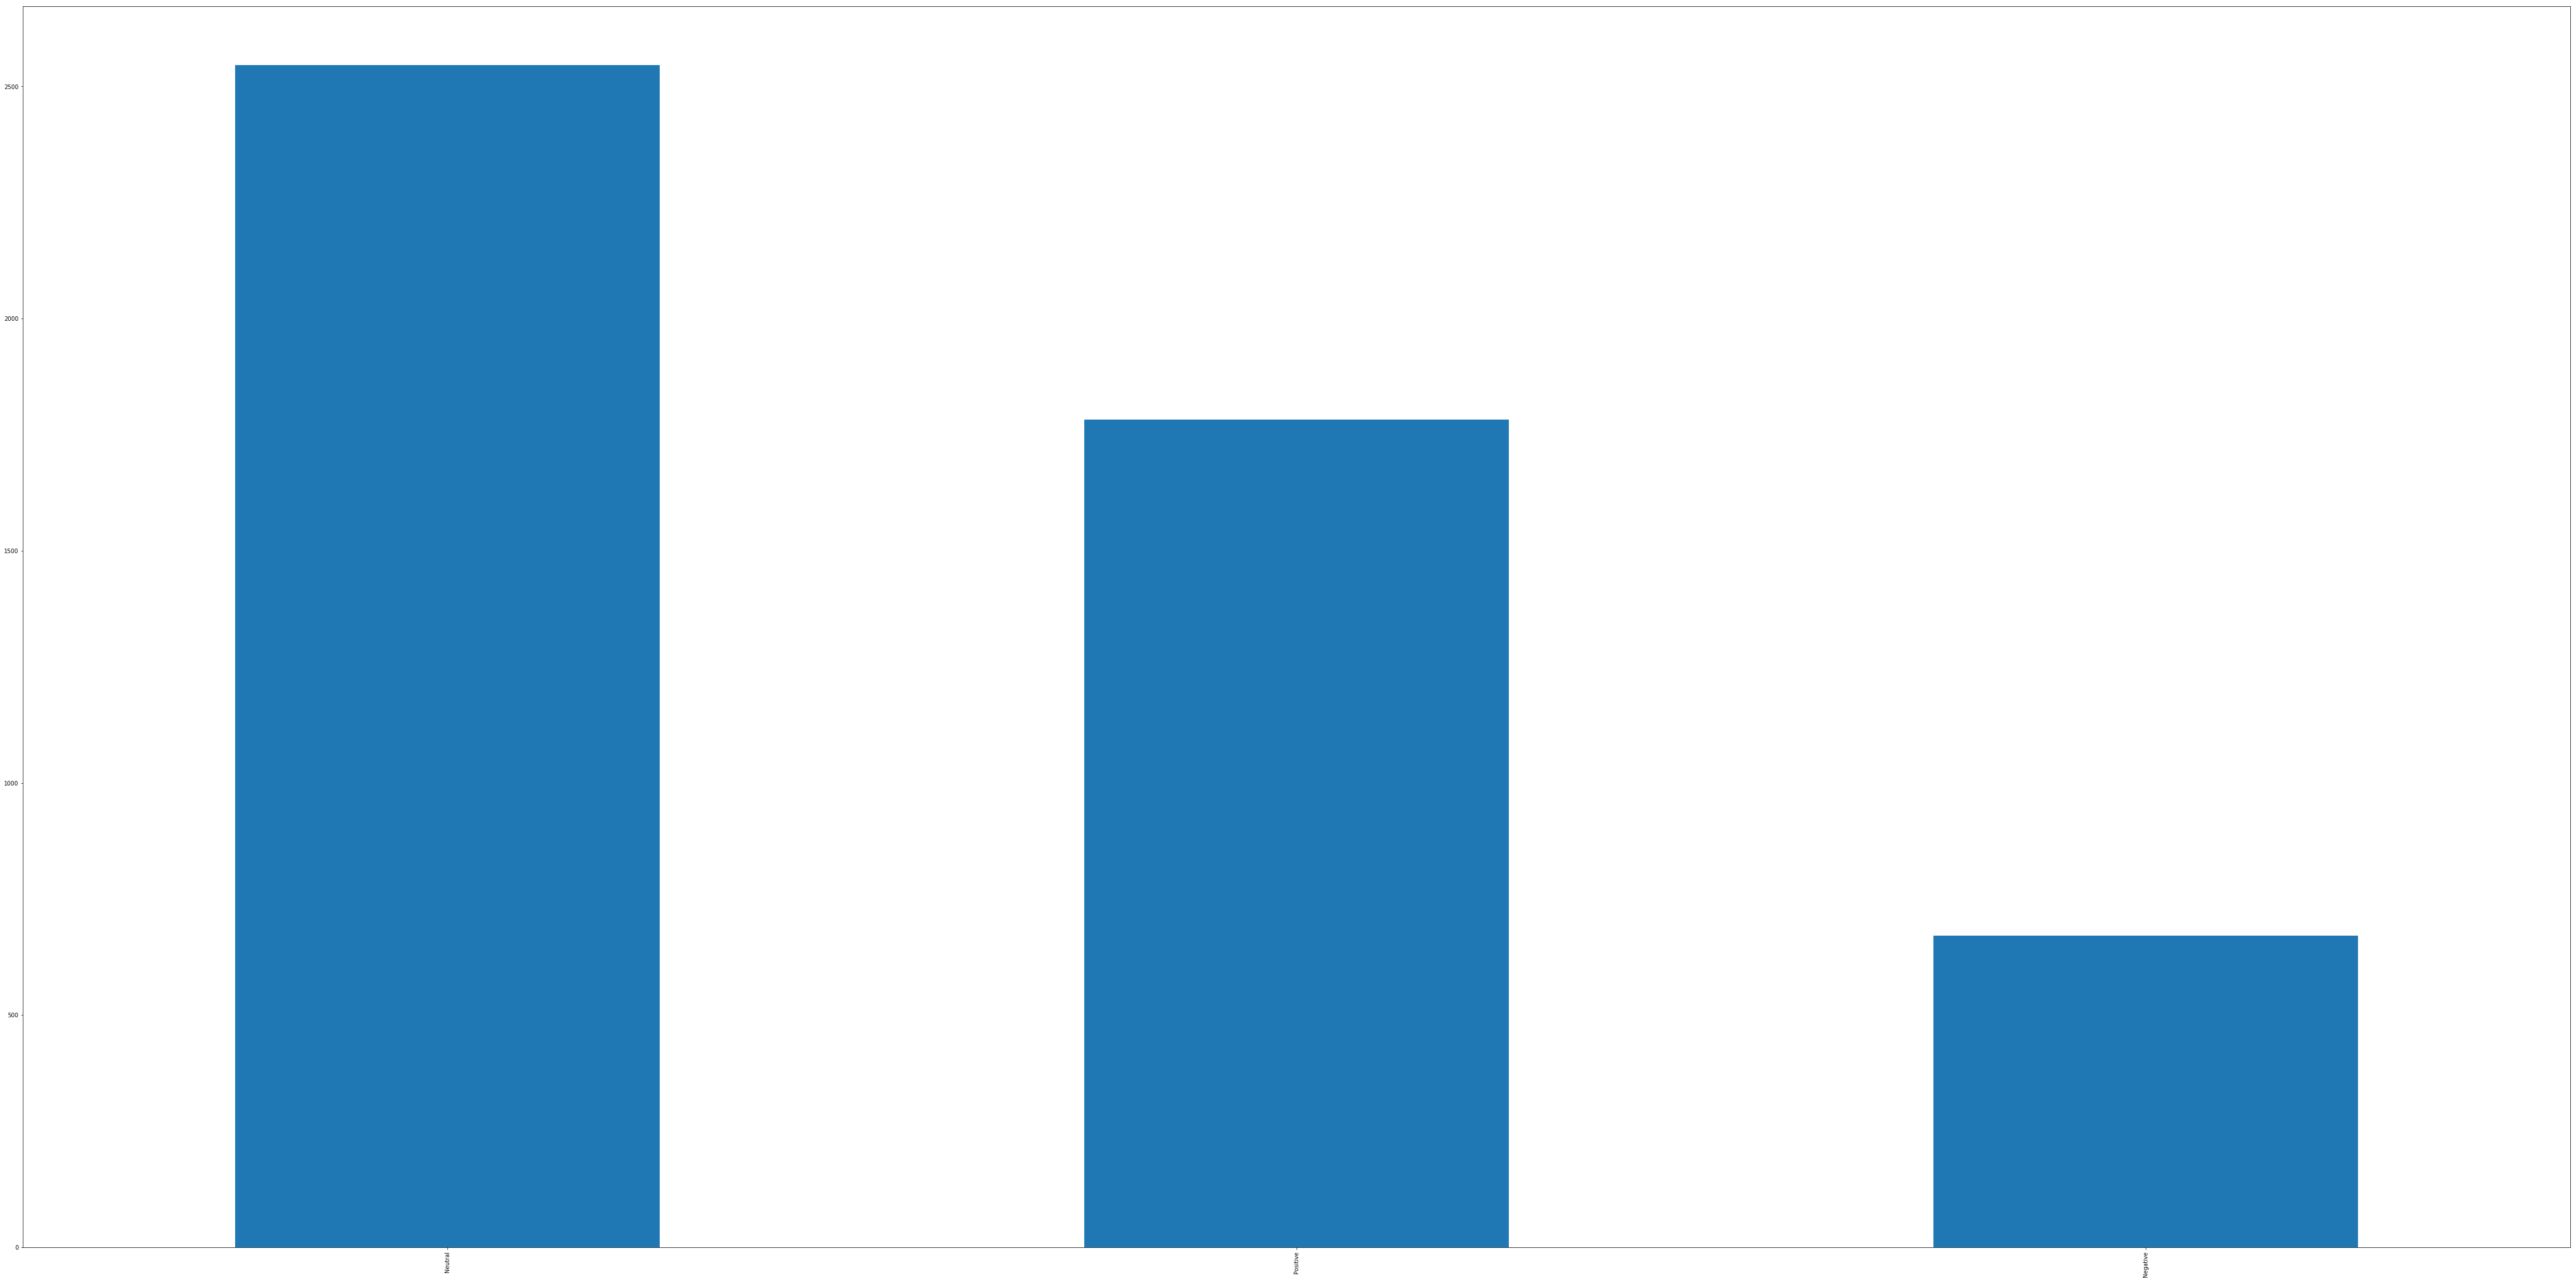

In [26]:
# Show the value counts
rawtext2_df['Analysis'].value_counts()

# Plot and visualise the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
rawtext2_df['Analysis'].value_counts().plot(kind='pie')
plt.show()
rawtext2_df['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [27]:
# Algotrading
# Create Signal
# buy = 1
# No action = 0
# Sell = -1
conditions = [
    (df_merged['Sentiment'] > 0.13),
    (df_merged['Sentiment'] <= 0.13) & (df_merged['Sentiment'] >= 0.03),
    (df_merged['Sentiment'] < 0.03),
    ]
values = [1.0, 0.0, -1.0]

In [28]:
df_merged['Signals'] = np.select(conditions, values)
df_merged

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Sentiment,Signals
Date,,,,,,,,,
2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,101467222687,0,0,0.064985,0.0
2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,91809846886,0,0,0.029858,-1.0
2021-02-10,46469.761719,47145.566406,43881.152344,44918.183594,87301089896,0,0,0.082648,0.0
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,0,0,0.122292,0.0
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,0,0,0.101058,0.0
2021-02-13,47491.203125,48047.746094,46392.281250,47105.515625,70250456155,0,0,0.215235,1.0
2021-02-14,47114.507812,49487.640625,47114.507812,48717.289062,71248675228,0,0,0.090220,0.0
2021-02-15,48696.535156,48875.570312,46347.476562,47945.058594,77069903166,0,0,0.076769,0.0
2021-02-16,47944.457031,50341.101562,47201.304688,49199.871094,77049582886,0,0,0.038164,0.0


In [29]:
initial_capital = float(1000000)
investment_coin = 0
for index, row in df_merged.iterrows():
    signal = row['Signals']
    print(row['Close'])
    
    if signal == (1.0): # Signal to go long. Assumption made to flip short to long, not short to just neutral.
            if investment_coin < 0:
                # Scenario where we have cash but -ve BTC
                # Already in a short trade
                # investment_coin = investment_coin
                initial_capital = initial_capital + (investment_coin * row['Close'])
                investment_coin = 0
                print()
                print("Close short")
                print(f"Capital ${initial_capital}")
                print(f"Number of BTC {investment_coin}")
                print()
            if initial_capital > 0:
                # Scenario where we do not have BTC but have cash
                # Currently in no trade, OR currently in a short with negative BTC.
                # We want to from neutral to long, or from short to long
                investment_coin = initial_capital / row['Close'] # This gives us the number of BTC
                initial_capital = 0 # 0 value because we bought all BTC
            # if investment_coin > 0, we are already in a long trade, so nothing happens.
                print()
                print("Open long")
                print(f"Capital ${initial_capital}")
                print(f"Number of BTC {investment_coin}")
                print()
                      
            
    elif signal == (-1.0): # Signal to go short. Assumption made to flip long to short, not long to just neutral.
            if investment_coin > 0:
                # Scenario where we have BTC but no cash
                # Already in a long trade
                initial_capital = investment_coin * row['Close']
                investment_coin = 0
                # Exiting the long trade to neutral. Before entering a short trade.
                print()
                print("Close long")
                print(f"Capital ${initial_capital}")
                print(f"Number of BTC {investment_coin}")
                print()
            if investment_coin == 0:
                # Scenario where we have cash but no BTC
                # We are neutral
                investment_coin = initial_capital / row['Close']
                initial_capital = initial_capital + (investment_coin * row['Close'])
                investment_coin = investment_coin * -1
                print()
                print("Open short")
                print(f"Capital ${initial_capital}")
                print(f"Number of BTC {investment_coin}")
                print()
            # if investment_coin < 0, we are already in a short trade, so nothing happens.
            
            
if initial_capital > 0:
        final_result = initial_capital
else:
        final_result = (investment_coin * df_merged['Close'].iloc[[-1]])
print()
print(f"Portfolio Value ${int(final_result)}")

46196.46484375
46481.10546875

Open short
Capital $2000000.0
Number of BTC -21.514118261931532

44918.18359375
47909.33203125
47504.8515625
47105.515625

Close short
Capital $986566.3660544864
Number of BTC 0


Open long
Capital $0
Number of BTC 20.94375473794607

48717.2890625
47945.05859375
49199.87109375
52149.0078125
51679.796875
55888.1328125
56099.51953125

Close long
Capital $1174934.5779791153
Number of BTC 0


Open short
Capital $2349869.1559582306
Number of BTC -20.94375473794607

57539.9453125
54207.3203125
48824.42578125
49705.33203125
47093.8515625
46339.76171875
46188.453125
45137.76953125
49631.2421875
48378.98828125
50538.2421875

Close short
Capital $1291408.6066963116
Number of BTC 0


Open long
Capital $0
Number of BTC 25.553097036994398

48561.16796875
48927.3046875
48912.3828125
51206.69140625
52246.5234375
54824.1171875
56008.55078125
57805.12109375
57332.08984375

Close long
Capital $1465012.4551110247
Number of BTC 0


Open short
Capital $2930024.9102220493
Numb